## Part 2A - Neutral synthetic B2C-like data
This notebook generates neutral, aggregated per-user data for an A/B experiment.

Goals:

heavy-tailed monetary outcomes (revenue)
heterogeneous activity (sessions)
correlated pre/post behavior (for CUPED demos)
three effect mechanisms: monetization, activity, mixed
Output schema:

user_id
group
sessions_pre, revenue_pre
sessions, revenue

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

np.random.seed(42)

## 1) Generate three scenarios
scenario_monetization - treatment increases revenue per session
scenario_activity - treatment increases sessions
scenario_mixed - treatment increases both slightly
All scenarios are domain-neutral: sessions and revenue are generic.

In [3]:
scenarios = make_default_scenarios(
    SyntheticB2CConfig(
        n_users=80_000,
        seed=42,
        sessions_mean_pre=3.0,
        sessions_mean_post=3.2,
        sessions_dispersion=1.6,
        high_spender_share=0.03,
        revps_lognorm_mu=-0.2,
        revps_lognorm_sigma=1.0,
        high_revps_multiplier=6.0,
        activity_latent_sigma=0.6,
        monetization_latent_sigma=0.7,
        include_binary=False,
    )
)

out_dir = Path("data/synthetic")
out_dir.mkdir(parents=True, exist_ok=True)

frames = {}
for name, cfg in scenarios.items():
    df = generate_user_level_data(cfg)
    frames[name] = df
    save_dataframe_csv(df, out_dir / f"{name}.csv")

list(frames.keys())

['scenario_monetization', 'scenario_activity', 'scenario_mixed']

## 2) Quick sanity checks
We check group balance, basic ranges, and metric magnitudes.

In [4]:
def quick_summary(df: pd.DataFrame) -> pd.DataFrame:
    g = df.groupby('group').agg(
        n_users=('user_id', 'count'),
        sessions_mean=('sessions', 'mean'),
        revenue_mean=('revenue', 'mean'),
        ratio_rev_per_session=('revenue', 'sum'),
        ratio_sessions=('sessions', 'sum'),
    )
    g['rev_per_session'] = g['ratio_rev_per_session'] / g['ratio_sessions']
    g = g.drop(columns=['ratio_rev_per_session', 'ratio_sessions'])
    return g

for name, df in frames.items():
    print('\n', '='*80)
    print(name)
    display(quick_summary(df))


scenario_monetization

scenario_activity

scenario_mixed


,n_users,sessions_mean,revenue_mean,rev_per_session
group,,,,
control,40257,3.202226,4.981365,1.555595
test,39743,3.224341,5.341376,1.656579


,n_users,sessions_mean,revenue_mean,rev_per_session
group,,,,
control,40257,3.202226,4.981365,1.555595
test,39743,3.341519,5.267748,1.576453


,n_users,sessions_mean,revenue_mean,rev_per_session
group,,,,
control,40257,3.202226,4.981365,1.555595
test,39743,3.241653,5.266316,1.624577


## 3) Visualize heavy tails and heterogeneity
We plot:

distribution of sessions per user
distribution of revenue per user
Note: revenue is heavy-tailed by design..

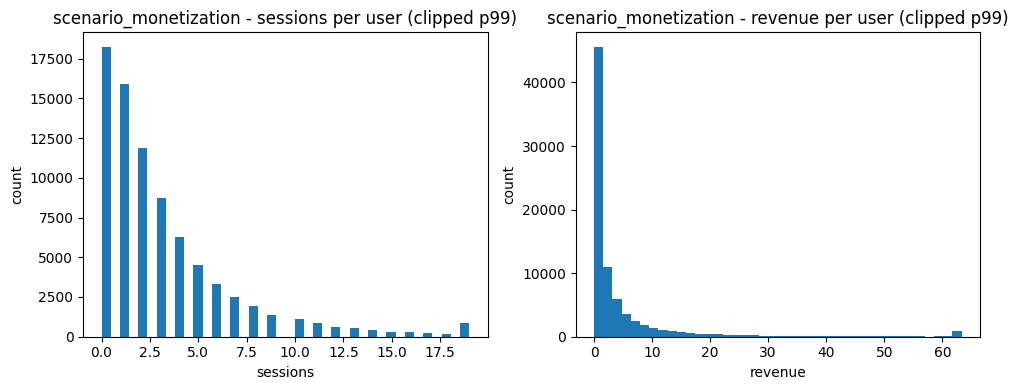

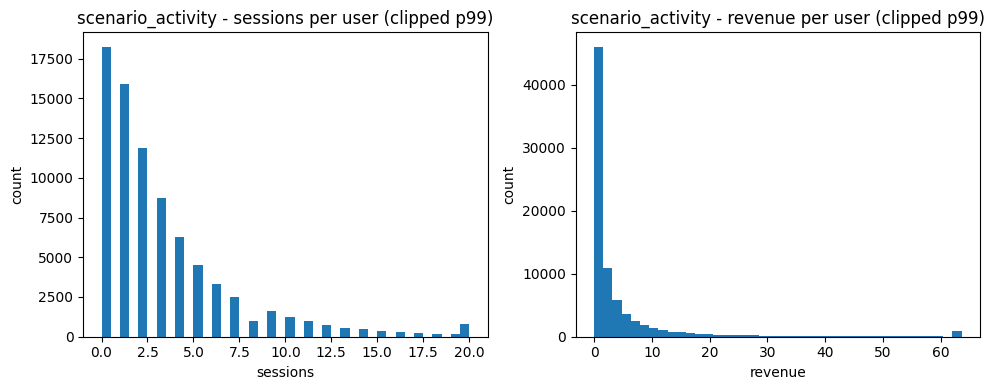

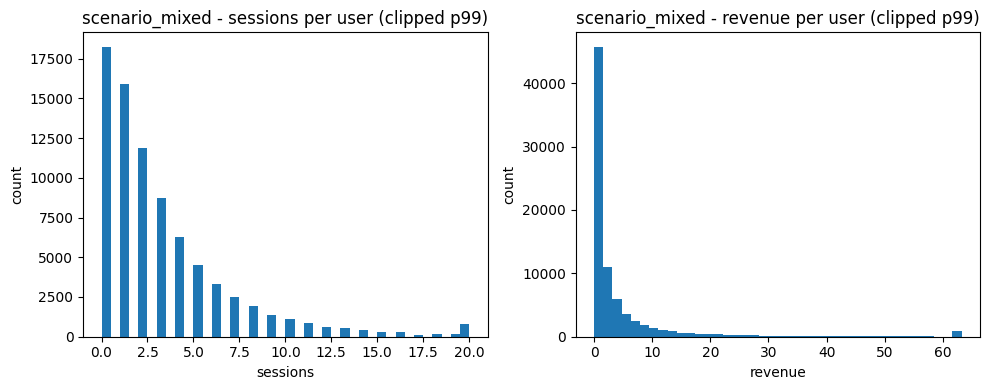

In [5]:
def plot_histograms(df: pd.DataFrame, title_prefix: str) -> None:
    fig = plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.hist(df['sessions'].clip(upper=np.quantile(df['sessions'], 0.99)), bins=40)
    plt.title(f"{title_prefix} - sessions per user (clipped p99)")
    plt.xlabel('sessions')
    plt.ylabel('count')

    plt.subplot(1, 2, 2)
    plt.hist(df['revenue'].clip(upper=np.quantile(df['revenue'], 0.99)), bins=40)
    plt.title(f"{title_prefix} - revenue per user (clipped p99)")
    plt.xlabel('revenue')
    plt.ylabel('count')

    plt.tight_layout()
    plt.show()

for name, df in frames.items():
    plot_histograms(df, name)

## 4) Save a short data description
This is useful for readers and for future pilot tests.

In [6]:
readme_path = out_dir / 'README.md'
readme_text = """# Synthetic data

Files:
- scenario_monetization.csv - treatment increases revenue per session
- scenario_activity.csv - treatment increases sessions
- scenario_mixed.csv - treatment increases both slightly

Schema:
- user_id - integer user identifier
- group - control / test
- sessions_pre - sessions in pre-period
- revenue_pre - revenue in pre-period
- sessions - sessions in experiment period
- revenue - revenue in experiment period

Notes:
- data is aggregated per user for a fixed analysis window
- revenue is heavy-tailed by design (mixture lognormal)
- pre/post are correlated (user-level latent factors) to enable CUPED demos
"""
readme_path.write_text(readme_text, encoding='utf-8')
readme_path

PosixPath('data/synthetic/README.md')

## Results summary
The datasets are generated and saved under data/synthetic.
Each scenario has realistic heavy tails in revenue and over-dispersion in sessions.
Group balance is approximately 50/50.